In [38]:
import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pandas as pd
import torch
import matplotlib.pyplot as plt
import warnings

from settings import INPUT_PATH
from utils.conn_data import load_pickle
from estimators.DependentBootstrapSampling import DependentBootstrapSampling
from signals.TSM import TSM

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## 1) Load relevant data

In [8]:
sysname = "training_etfstsm"
instruments = [

    'SPY', 'IWM', 'EEM', 'TLT', 'USO', 'GLD', 'XLF',
    'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY', 'XLP',
    'XLE', 'VIX', 'AGG', 'DBC', 'HYG', 'LQD','UUP'

]
bar_name = "Close"

# inputs
inputs = load_pickle(os.path.join(INPUT_PATH, sysname, f"{sysname}.pickle"))
bars_info = inputs["bars"]

## 2) Bootstrap samples

Our goal is ot cpmpute bootstrap utilies and perform robust optmization on them. 

To do so, we need to define a hyperparameter space and a signal function. For this experiement, the signal function is the key component. Different signal functions will recieve as input differnt transformations of the original data and them process it properly. This implies that we must apply the boostrap methods on the data domain that the signal must recieve as input.

Consider the time series momentum signal as defined in Moskowitz et al. (2012). This signal function recieves prices and outputs rolling means of log-returns. Thus, our bootstrap method should resample the prices data accordingly and feed this into the signal function as defined in Moskowitz et al. (2012).

In [12]:
input = []
for instrument in instruments:
    input.append(bars_info[instrument][[bar_name]].rename(columns={bar_name: instrument}))

input_df = pd.concat(input, axis=1)
input_tensor = torch.tensor(input_df.values, dtype=torch.float32)

In [66]:
boostrap = DependentBootstrapSampling(time_series=input_tensor,
                                      boot_method="nobb",
                                      Bsize=input_df.shape[0])

In [67]:
boostrap.Blocks

[tensor([[144.0200,  80.3000,  40.0733,  ..., 104.3500, 106.3200,  24.8470],
         [144.6600,  80.8400,  40.7433,  ..., 104.4200, 106.4800,  24.7000],
         [145.3200,  81.4000,  40.9900,  ..., 104.2300, 106.3000,  24.6900],
         ...,
         [454.2600, 179.3300,  39.8500,  ...,  74.8500, 104.8100,  29.2100],
         [453.2700, 177.0200,  39.6000,  ...,  74.9500, 104.8400,  29.2400],
         [455.0300, 178.1300,  39.5200,  ...,  75.0800, 105.2600,  29.3400]])]

<Axes: xlabel='date'>

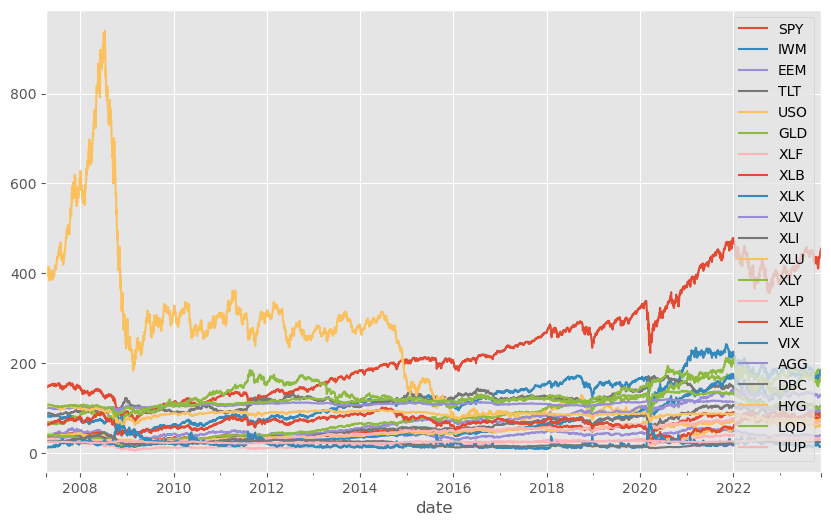

In [60]:
input_df.plot(figsize=(10, 6))

<Axes: >

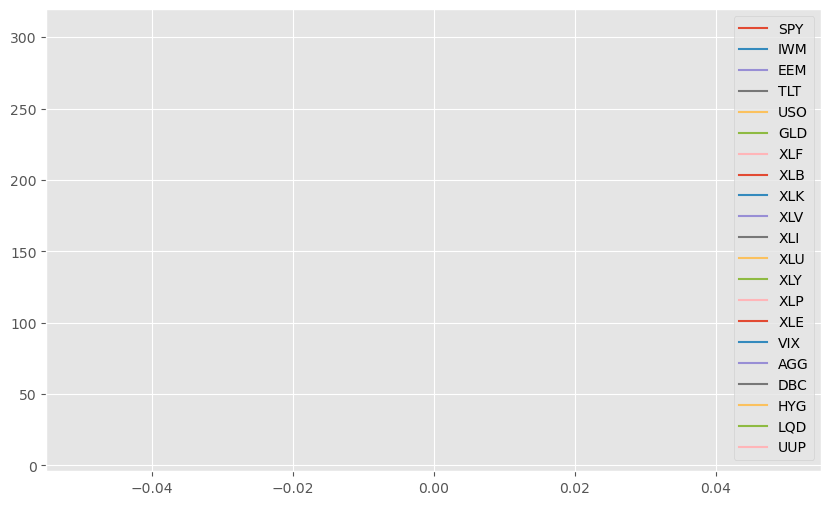

In [61]:
first_block_df.plot(figsize=(10, 6))

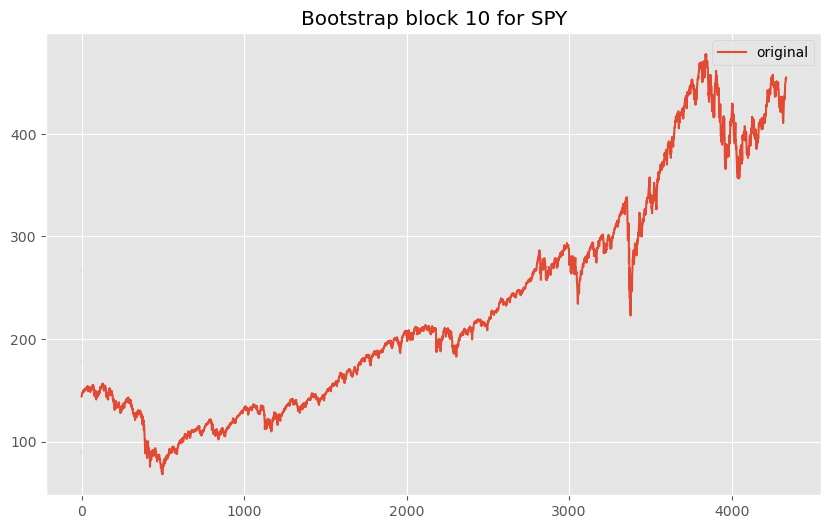

In [62]:
instrument = "SPY"

# Plot the original data first
plt.figure(figsize=(10, 6))
plt.plot(input_df[instrument].reset_index(drop=True), label="original")

# Plot each bootstrap sample individually without labels
for i in range(10):
    plt.plot(pd.DataFrame(boostrap.Blocks[i], columns=input_df.columns)[instrument], color='gray', alpha=0.1)

plt.legend()
plt.title(f"Bootstrap block {num_block} for {instrument}")
plt.show()